In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
import tensorflow as tf



In [2]:
df = pd.read_csv("../data/classification_data.csv")
df_demo = pd.read_csv("../data/demographics-data/classification_data_demographics.csv")

In [4]:
df.head()

,MonthOccurrence,TotalNumberOfVictims,TotalNumberOfIndividualVictims,SuspectsRaceAsAGroup,TotalNumberOfSuspects,MostSeriousUcr,MostSeriousUcrType,MostSeriousLocation,MostSeriousBias,MostSeriousBiasType,MostSeriousVictimType,WeaponType,Offensive_Act,labels
0,2,1,1,White,2,Simple Assault,Violent Crimes,Bar/Night Club,Anti-Black or African American,Race/Ethnicity/Ancestry,Person,"Personal weapons (hands, feet, teeth, etc.)",Verbal slurs,1
1,2,2,2,White,1,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Black or African American,Race/Ethnicity/Ancestry,Person,None,Graffiti,1
2,5,1,1,White,4,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Hispanic or Latino,Race/Ethnicity/Ancestry,Person,None,Daubing of swastika,1
3,9,1,1,White,1,Intimidation,Violent Crimes,Residence/Home/Driveway,Anti-Hispanic or Latino,Race/Ethnicity/Ancestry,Person,None,Verbal slurs,1
4,9,2,2,White,1,Intimidation,Violent Crimes,Convenience Store,Anti-Other Race/Ethnicity/Ancestry,Race/Ethnicity/Ancestry,Person,None,Verbal slurs,1


In [5]:
#move target to end
df_demo = df_demo[[col for col in df_demo if col != 'labels']+ ['labels']]

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24436 entries, 0 to 24435
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   MonthOccurrence                 24436 non-null  int64 
 1   TotalNumberOfVictims            24436 non-null  int64 
 2   TotalNumberOfIndividualVictims  24436 non-null  int64 
 3   SuspectsRaceAsAGroup            24436 non-null  object
 4   TotalNumberOfSuspects           24436 non-null  int64 
 5   MostSeriousUcr                  24436 non-null  object
 6   MostSeriousUcrType              24436 non-null  object
 7   MostSeriousLocation             24436 non-null  object
 8   MostSeriousBias                 24436 non-null  object
 9   MostSeriousBiasType             24436 non-null  object
 10  MostSeriousVictimType           24436 non-null  object
 11  WeaponType                      24436 non-null  object
 12  Offensive_Act                   24436 non-null

## X, y & Train Test Split

In [102]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_demo = df_demo.iloc[:,:-1]
y_demo = df_demo.iloc[:,-1]

y = utils.to_categorical(y, num_classes=3)
y_demo = utils.to_categorical(y_demo, num_classes=3)

In [104]:
#Encode Features
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)
X_encoded = ct.fit_transform(X)
X_encoded = pd.DataFrame(X_encoded, columns=ct.get_feature_names_out())

X_encoded_demo = ct.fit_transform(X_demo)
X_encoded_demo = pd.DataFrame(X_encoded_demo, columns=ct.get_feature_names_out())

#Scale X
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_encoded)
X_test_ss = ss.transform(X_test_encoded)
X_ss_demo = StandardScaler().fit_transform(X_encoded_demo)

In [63]:
X_test_ss.shape

(6109, 150)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, stratify=y, random_state=13)
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X_ss_demo, y_demo, stratify=y_demo, random_state=13)

In [54]:
df['labels'].value_counts(normalize=True)

1    0.728433
0    0.168726
2    0.102840
Name: labels, dtype: float64

## Build Neural Net

In [115]:

model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(.01)))
model.add(Dropout(.2))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(.02)))
model.add(Dense(3, activation='softmax'))

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

history = model.fit(
    X_train_demo,
    y_train_demo,
    validation_data = (X_test_demo, y_test_demo),
    epochs=100,
    batch_size=100,
    callbacks=EarlyStopping(monitor='val_loss', patience=7),
    class_weight={0:.1687, 1:.7284, 2:.1029},
    verbose=2
)

Epoch 1/100
184/184 - 3s - loss: 0.7116 - accuracy: 0.7652 - val_loss: 0.7365 - val_accuracy: 0.8258 - 3s/epoch - 15ms/step
Epoch 2/100
184/184 - 1s - loss: 0.1532 - accuracy: 0.8337 - val_loss: 0.4902 - val_accuracy: 0.8414 - 1s/epoch - 7ms/step
Epoch 3/100
184/184 - 1s - loss: 0.0951 - accuracy: 0.8430 - val_loss: 0.4360 - val_accuracy: 0.8432 - 965ms/epoch - 5ms/step
Epoch 4/100
184/184 - 1s - loss: 0.0796 - accuracy: 0.8550 - val_loss: 0.3704 - val_accuracy: 0.8679 - 790ms/epoch - 4ms/step
Epoch 5/100
184/184 - 1s - loss: 0.0702 - accuracy: 0.8730 - val_loss: 0.3513 - val_accuracy: 0.8726 - 794ms/epoch - 4ms/step
Epoch 6/100
184/184 - 1s - loss: 0.0633 - accuracy: 0.8789 - val_loss: 0.3175 - val_accuracy: 0.8769 - 940ms/epoch - 5ms/step
Epoch 7/100
184/184 - 1s - loss: 0.0579 - accuracy: 0.8808 - val_loss: 0.3800 - val_accuracy: 0.8695 - 923ms/epoch - 5ms/step
Epoch 8/100
184/184 - 1s - loss: 0.0540 - accuracy: 0.8833 - val_loss: 0.2726 - val_accuracy: 0.8856 - 924ms/epoch - 5ms/st

## Evaluate Model

In [116]:
preds = np.argmax(model.predict(X_test_demo), axis=1)

In [119]:
model.evaluate(X_train_demo, y_train_demo)

573/573 [==============================] - 3s 6ms/step - loss: 0.0361 - accuracy: 0.9957


[0.036113008856773376, 0.9956893920898438]

In [117]:
model.evaluate(X_test_demo, y_test_demo)

191/191 [==============================] - 1s 3ms/step - loss: 0.0995 - accuracy: 0.9797


[0.09951414912939072, 0.9797020554542542]

In [120]:
train_preds = np.argmax(model.predict(X_train_demo), axis=1)
balanced_accuracy_score(np.argmax(y_train_demo, axis=1), train_preds)

0.9895505822323001

In [118]:
balanced_accuracy_score(np.argmax(y_test_demo, axis=1), preds)

0.9591416400513215

<Figure size 720x720 with 0 Axes>

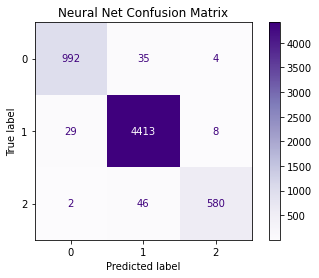

In [130]:
plt.figure(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test_demo, axis=1), preds, cmap="Purples")
plt.title("Neural Net Confusion Matrix")
plt.savefig("../plots/NN_CMD.png", transparent=True)